In [20]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
from m3util.viz.style import set_style
from m3util.viz.printing import printer
from m3util.viz.layout import layout_fig
from dl_utils.training.build_model import resnet50_
from dl_utils.analysis.confusion_matrix import confusion_matrix, plot_cm, show_multiple_cm
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, generate_prediction_example
from dl_utils.packed_functions import generate_attention_maps

printing = printer(basepath = '../../figures/ConfusionMatrix/', fileformats=['png', 'svg'], dpi=600)
set_style("printing")

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


## Compare different dataset size with ResNet50 results

Scale of dataset matters when utilize DL models to understand physical information.

../../figures/ConfusionMatrix/cm-compare_ds_size.png
../../figures/ConfusionMatrix/cm-compare_ds_size.svg


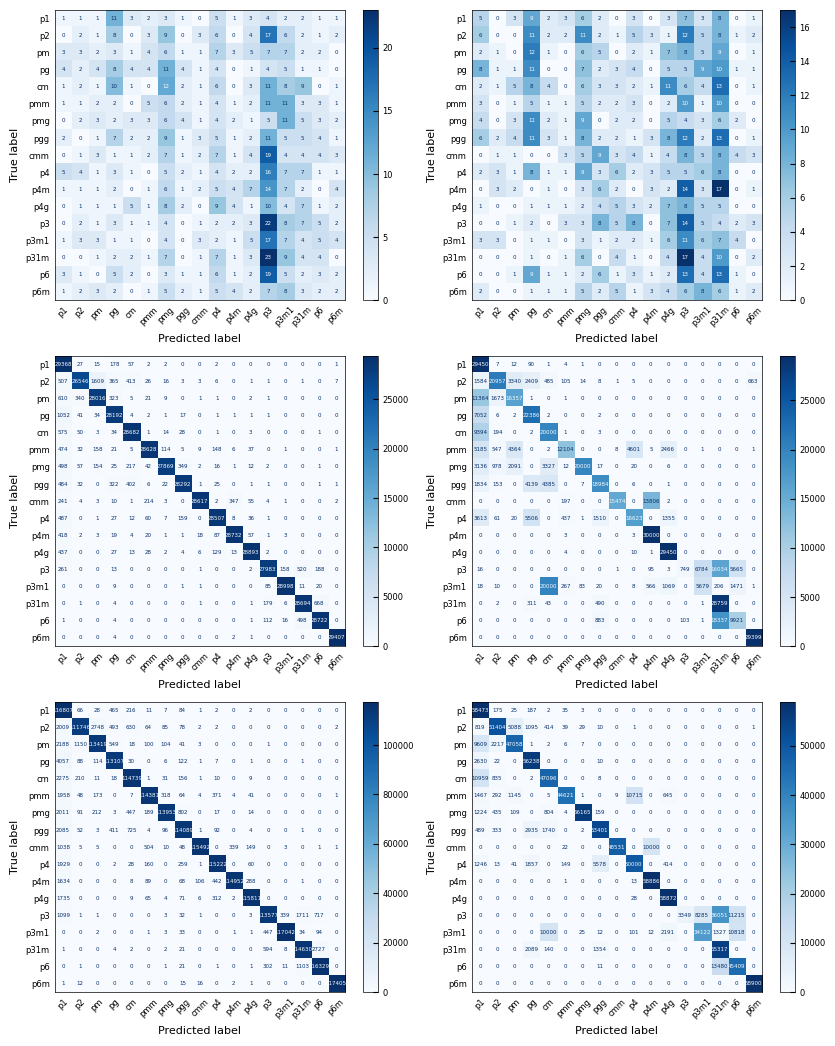

In [34]:
cm_files = [
            '../../results/ResNet50/09052024-resnet50-dataset_v5_size-1k-imagenet_train_cm.npy',
            '../../results/ResNet50/09052024-resnet50-dataset_v5_size-1k-atom_cross_validation_cm.npy',
            '../../results/ResNet50/09022024-resnet50-dataset_v5_size-500k-imagenet_train_cm.npy',
            '../../results/ResNet50/09022024-resnet50-dataset_v5_size-500k-atom_cross_validation_cm.npy',
            '../../results/ResNet50/09052024-resnet50-dataset_v5_size-2m-imagenet_train_cm.npy',
            '../../results/ResNet50/09052024-resnet50-dataset_v5_size-2m-atom_cross_validation_cm.npy',
            ]
fig, axes = layout_fig(len(cm_files), 2, figsize=(8.5, 10.5), layout='tight')
for i, cm_file in enumerate(cm_files):
    cm = np.load(cm_file)
    plot_cm(cm, symmetry_classes, ax=axes[i], font_size=4)
    
printing.savefig(fig, 'cm-compare_ds_size')
plt.show()

### Choose pm (true) -> p1 (prediction) pair as example to demonstrate the model performance improving with dataset size increase prediction change from random guess (1k) to mostly wrong prediction (500k) to mostly correct prediction (2m).

#### Use model trained trianed with 1k dataset 

In [ ]:
group = 'imagenet'
device = torch.device('cpu')
visualizer = AttentionMapVisualizer(device=device)
layers = ['layer4', 'layer3', 'layer2', 'layer1']
task_name = ''
ds_path_dict = {'imagenet': '../../datasets/imagenet_v5_rot_10m_fix_vector.h5',
                'atom': '../../datasets/atom_v5_rot_1m_fix_vector.h5'}

In [42]:
model_path = '../../models/ResNet50/09052024-resnet50-dataset_v5_size-1k/model_epoch_6700.pth'
model = resnet50_(in_channels=3, n_classes=17)
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.eval()
model_type = 'resnet50'

confusion_pair=('pm', 'p1')
img, label, top_predictions, probs, metadata, info = generate_prediction_example(model, ds_path_dict['imagenet'], confusion_pair=confusion_pair,classes=symmetry_classes, device=device, batch_limit=1000000, group=group, viz=False)
print(info)
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(img, metadata, layers, task_name, model, model_type, device, filename=None, viz=True)

img, label, top_predictions, probs, metadata, info = generate_prediction_example(model, ds_path_dict['atom'], confusion_pair=confusion_pair,classes=symmetry_classes, device=device, batch_limit=1000000, group=group, print=True, viz=False)
print(info)
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(img, metadata, layers, task_name, model, model_type, device, filename=None, viz=True)

confusion_pair=('pm', 'pm')
img, label, top_predictions, probs, metadata, info = generate_prediction_example(model, ds_path_dict['imagenet'], confusion_pair=confusion_pair,classes=symmetry_classes, device=device, batch_limit=1000000, group=group, print=True, viz=False)
print(info)
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(img, metadata, layers, task_name, model, model_type, device, filename=None, viz=True)

img, label, top_predictions, probs, metadata, info = generate_prediction_example(model, ds_path_dict['atom'], confusion_pair=confusion_pair,classes=symmetry_classes, device=device, batch_limit=1000000, group=group, print=True, viz=False)
print(info)
input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(img, metadata, layers, task_name, model, model_type, device, filename=None, viz=True)

True: pm | Predicted: p1
p1: 99.99%, p2: 0.00%, p3m1: 0.00%, pg: 0.00%, p6m: 0.00%


TypeError: generate_attention_maps() missing 1 required positional argument: 'device'

True: pm | Predicted: p1
p1: 12.97%, pg: 11.76%, pgg: 11.70%, p4: 9.56%, p4m: 8.00%


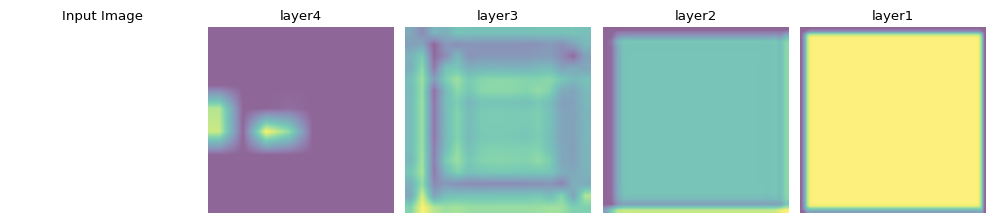

True: pm | Predicted: p1
p1: 100.00%, p2: 0.00%, pg: 0.00%, pm: 0.00%, pmg: 0.00%


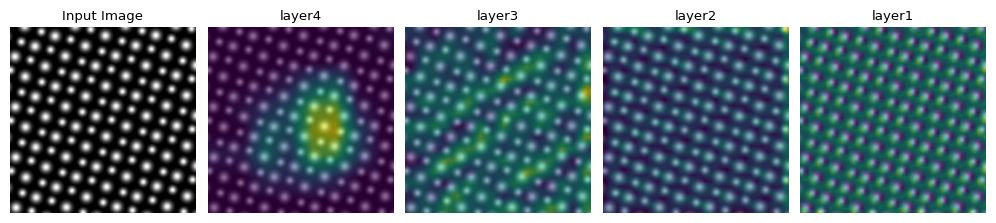

True: pm | Predicted: pm
pm: 100.00%, p2: 0.00%, pg: 0.00%, p1: 0.00%, pmg: 0.00%


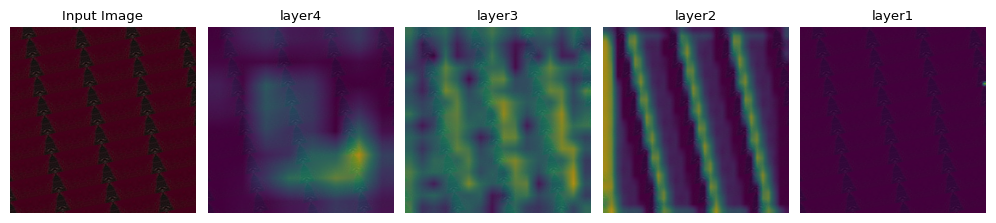

True: pm | Predicted: pm
pm: 99.94%, p2: 0.06%, pg: 0.00%, p1: 0.00%, pmm: 0.00%


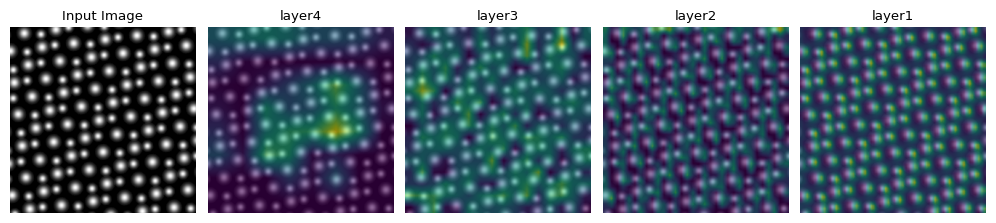

In [37]:
model_path = '../../models/ResNet50/09022024-resnet50-dataset_v5_size-500k/model_epoch_200.pth'

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/imagenet_v5_rot_10m_fix_vector.h5', group='imagenet', confusion_pair=('pm', 'p1'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/atom_v5_rot_1m_fix_vector.h5', group='atom', confusion_pair=('pm', 'p1'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/imagenet_v5_rot_10m_fix_vector.h5', group='imagenet', confusion_pair=('pm', 'pm'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/atom_v5_rot_1m_fix_vector.h5', group='atom', confusion_pair=('pm', 'pm'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

True: pm | Predicted: p1
p1: 16.05%, pgg: 14.43%, pg: 12.21%, p4: 9.32%, cm: 8.22%


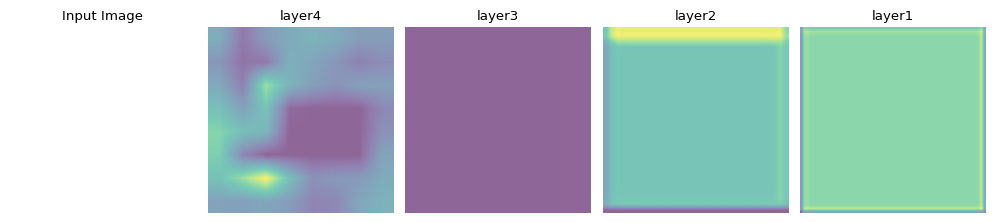

True: pm | Predicted: p1
p1: 87.17%, p2: 7.58%, pm: 4.79%, pg: 0.18%, pmg: 0.16%


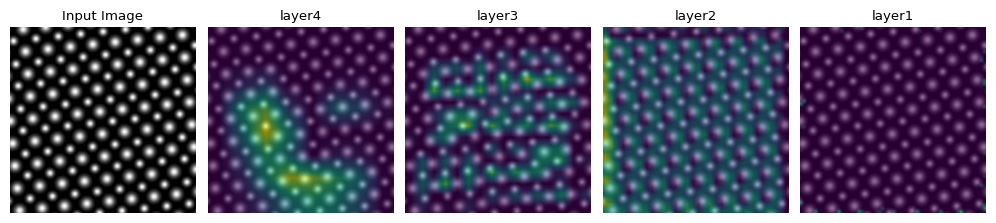

True: pm | Predicted: pm
pm: 100.00%, p2: 0.00%, pg: 0.00%, p1: 0.00%, pmg: 0.00%


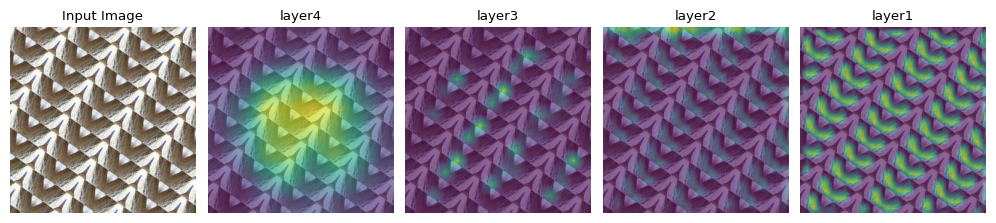

True: pm | Predicted: pm
pm: 99.68%, p2: 0.31%, p1: 0.00%, pmm: 0.00%, pg: 0.00%


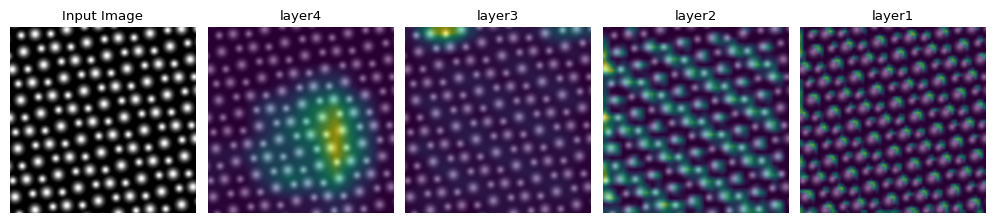

In [38]:
model_path = '../../models/ResNet50/09052024-resnet50-dataset_v5_size-2m/model_epoch_40.pth'

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/imagenet_v5_rot_10m_fix_vector.h5', group='imagenet', confusion_pair=('pm', 'p1'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/atom_v5_rot_1m_fix_vector.h5', group='atom', confusion_pair=('pm', 'p1'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/imagenet_v5_rot_10m_fix_vector.h5', group='imagenet', confusion_pair=('pm', 'pm'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)

input_image_np, overlay_attention_map_list, overlay_attention_map_list = generate_attention_maps(ds_path=f'../../datasets/atom_v5_rot_1m_fix_vector.h5', group='atom', confusion_pair=('pm', 'pm'), layers=layers, task_name='', model_type=model_type, model_path=model_path, device=device, filename=None, viz=True)